In [1]:
import os
import sys
import torch
from transformers import BertTokenizer,squad_convert_examples_to_features, AutoConfig, AutoModelForQuestionAnswering
from transformers.data.processors.squad import SquadV2Processor
from torch.utils.data import DataLoader, RandomSampler
from tqdm import tqdm, trange
import matplotlib.pyplot as plt

In [12]:
model_dir = 'bert-base-uncased'
model_prefix = 'bert-base-uncased'
data_dir = ''
data_file = 'train-v2.0.json'
max_seq_length = 384
non_linear = "gelu"
project_dim = 200
layers = 12
hidden_dim = 768
epochs = 1
batch_size = 8
adam_epsilon = 1e-8
max_grad_norm = 0.1
dropout_r = 0.5
lr = 5e-5

In [3]:
# GPU
if torch.cuda.is_available():       
    device = 'cuda'
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = 'cpu'

# Tokenizer
tokenizer = BertTokenizer.from_pretrained(model_prefix)

# Extract examples
processor = SquadV2Processor()
train_examples = processor.get_train_examples(data_dir=data_dir, filename=data_file)

We will use the GPU: GeForce GTX 1050 Ti with Max-Q Design


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 442/442 [01:07<00:00,  6.56it/s]


In [4]:
# Extract train features
print("Loading train features")
train_features, train_dataset = squad_convert_examples_to_features(
    examples=train_examples[0:10000],
    tokenizer=tokenizer,
    max_seq_length=max_seq_length,
    doc_stride=128,
    max_query_length=64,
    is_training=True,
    return_dataset="pt",
    threads=1,
)

Loading train features


add example index and unique id: 100%|█████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 1258190.54it/s]


In [5]:
# Initialize model
#from ProbeAttention import *

config = AutoConfig.from_pretrained(model_prefix, output_hidden_states = True)
model = AutoModelForQuestionAnswering.from_pretrained(model_prefix, config = config)

# multi-gpu evaluate one at here
model = model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForQuestionAnswering: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-uncased a

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import AdamW
import numpy as np

class Adapter(nn.Module):
    def __init__(self, in_dim, project_dim, non_linear, p = dropout_r, max_seq = max_seq_length):
        super(Adapter, self).__init__()        
        assert non_linear in ["relu","gelu","tanh"]
        
        if (non_linear == "relu"):
            self.non_linear = nn.ReLU()
        elif (non_linear == "gelu"):
            self.non_linear = nn.GELU()
        elif (non_linear == "tanh"):
            self.non_linear = nn.Tanh()
                
        self.project_down = nn.Linear(in_dim, project_dim)
        self.project_up = nn.Linear(project_dim, in_dim)
        self.dropout = nn.Dropout(p=p)
        self.batchnorm = nn.BatchNorm1d(max_seq)
        self.layernorm = nn.LayerNorm(in_dim, max_seq)
        
    def forward(self, h):
        h = self.project_down(h)
        #print(h.size()) ->　(8,384,200)
        h = self.batchnorm(h)
        h = self.non_linear(h)
        h = self.dropout(h)
        h = self.project_up(h)
        h = self.layernorm(h)
        
        return h

class AdapterModel(nn.Module):
    def __init__(self, in_dim, project_dim, non_linear, max_seq=max_seq_length):
        super(AdapterModel, self).__init__()
        
        self.adpt_list = nn.ModuleList([Adapter(in_dim, project_dim, non_linear) for i in range(12)])
        self.linear = nn.Linear(in_dim, 1)
    
    def forward(self, all_h):
        h = torch.zeros(all_h[0].size()).to(device)
        
        for i in range(12):
            h = self.adpt_list[i](h+all_h[i])
            
        return self.linear(h).unsqueeze(0)

In [9]:
# Initialize adaptors
print("Initializing adaptors")
adaptor_s = AdapterModel(hidden_dim, project_dim, non_linear)
adaptor_e = AdapterModel(hidden_dim, project_dim, non_linear)

adaptor_s.to(device)
adaptor_e.to(device)

start_optimizer = AdamW(adaptor_s.parameters(), lr=lr, eps=adam_epsilon, correct_bias=False)
end_optimizer = AdamW(adaptor_e.parameters(), lr=lr, eps=adam_epsilon, correct_bias=False)

Initializing adaptors


Iteration:   0%|                                                                                                 | 0/1269 [00:00<?, ?it/s]

Training epoch: 1


Iteration:   8%|██████▊                                                                                | 100/1269 [01:13<14:37,  1.33it/s]

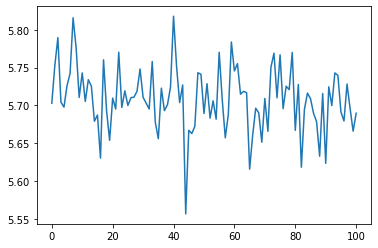

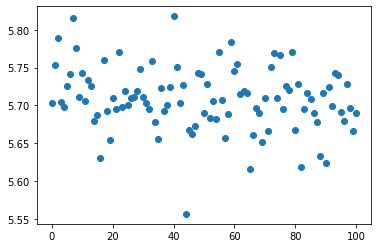

Iteration:  16%|█████████████▋                                                                         | 200/1269 [02:30<13:18,  1.34it/s]

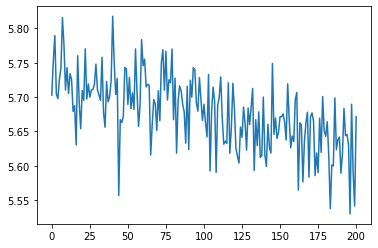

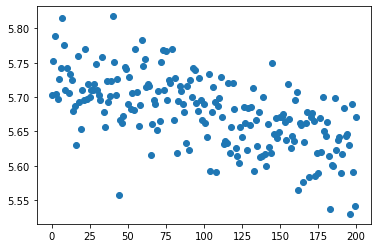

Iteration:  24%|████████████████████▌                                                                  | 300/1269 [03:51<12:51,  1.26it/s]

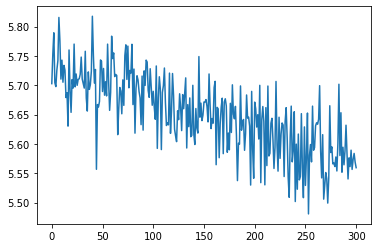

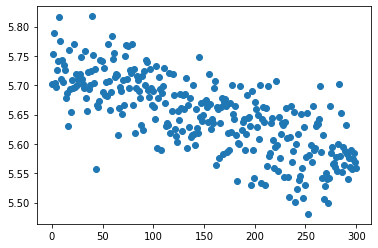

Iteration:  32%|███████████████████████████▍                                                           | 400/1269 [05:07<10:45,  1.35it/s]

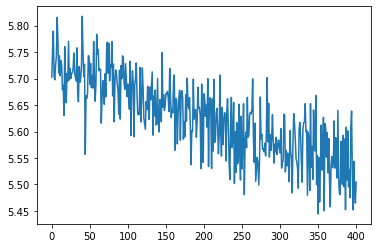

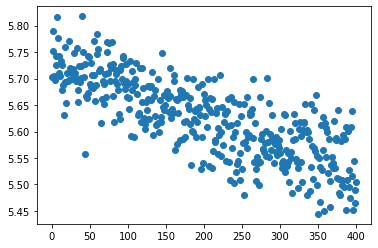

Iteration:  39%|██████████████████████████████████▎                                                    | 500/1269 [06:29<13:29,  1.05s/it]

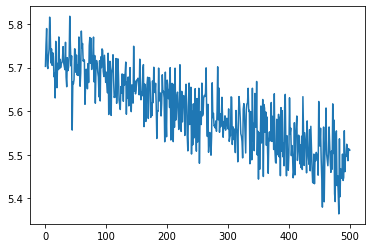

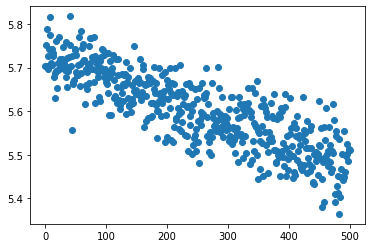

Iteration:  47%|█████████████████████████████████████████▏                                             | 600/1269 [07:49<08:22,  1.33it/s]

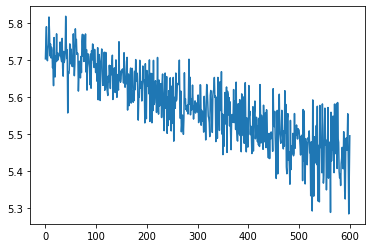

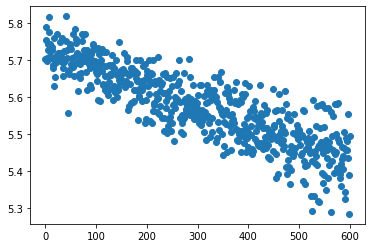

Iteration:  55%|███████████████████████████████████████████████▉                                       | 700/1269 [09:02<07:16,  1.30it/s]

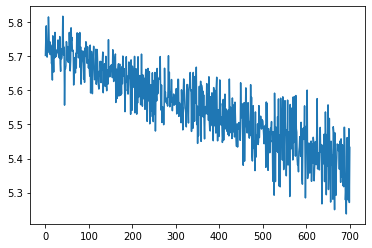

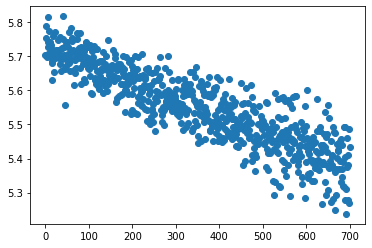

Iteration:  63%|██████████████████████████████████████████████████████▊                                | 800/1269 [10:24<05:40,  1.38it/s]

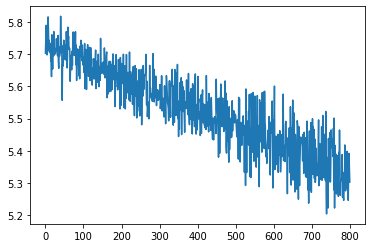

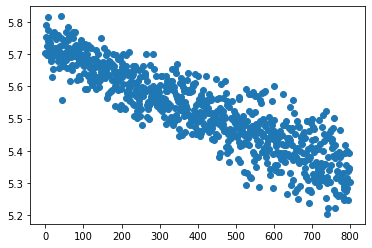

Iteration:  71%|█████████████████████████████████████████████████████████████▋                         | 900/1269 [11:46<04:31,  1.36it/s]

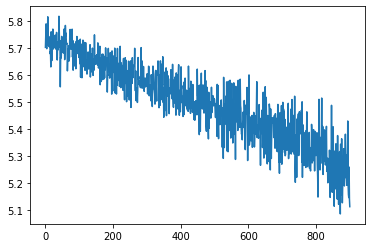

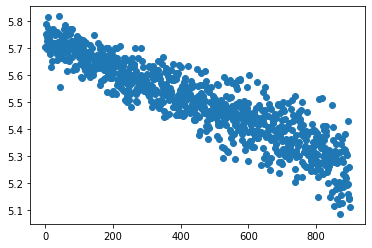

Iteration:  79%|███████████████████████████████████████████████████████████████████▊                  | 1000/1269 [13:08<03:37,  1.24it/s]

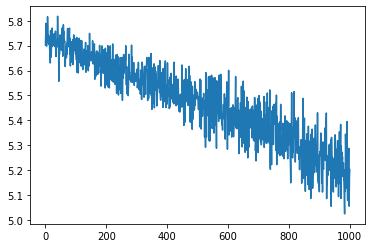

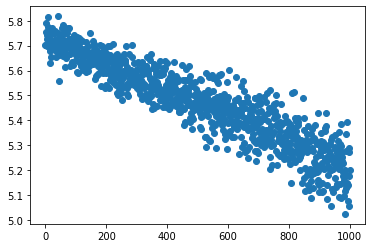

Iteration:  87%|██████████████████████████████████████████████████████████████████████████▌           | 1100/1269 [14:35<02:36,  1.08it/s]

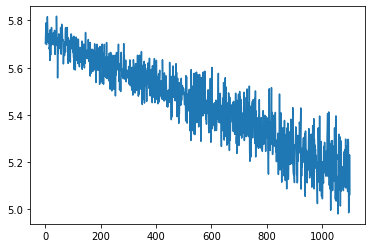

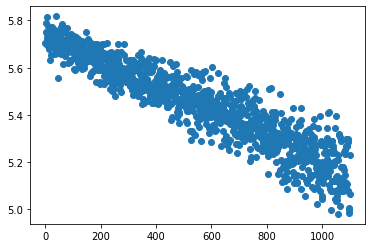

Iteration:  95%|█████████████████████████████████████████████████████████████████████████████████▎    | 1200/1269 [16:13<00:52,  1.31it/s]

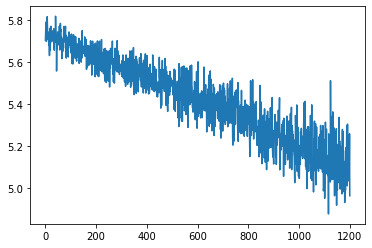

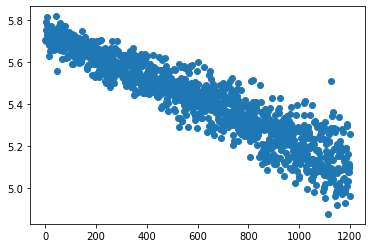

Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████| 1269/1269 [17:04<00:00,  1.24it/s]

Epoch loss 6854.116231918335
Epoch 1 complete, saving probes


In [16]:
# minimum loss
min_loss = 1000000000
    
# start & end hidden state
start_hidden={}
end_hidden={}

# create results folder
if not os.path.exists('results'):
        os.mkdir('results')
        
if not os.path.exists('results'+'/'+ model_prefix):
        os.mkdir('results'+'/'+ model_prefix)
# Training epochs
for epoch in range(epochs):
    
    # create each epochs folder    
    epoch_dir = "results"+"/"+ model_prefix + "/"+"epoch_" + str(epoch + 1)
    if not os.path.exists(epoch_dir):
        os.mkdir(epoch_dir)
    
    print("Training epoch: {}".format(epoch+1))
    adaptor_s.train()
    adaptor_e.train()

    # Track epoch loss
    epoch_loss = 0

    # Initialize train data loader
    train_sampler = RandomSampler(train_dataset)
    train_dataloader = DataLoader(train_dataset, sampler = train_sampler, batch_size = batch_size)
    loss_list = []
    
    iter=0
    for batch in tqdm(train_dataloader, desc = "Iteration"):
        
        # Get batch on the right device and prepare input dict
        batch = tuple(t.to(device) for t in batch)

        inputs = {
            "input_ids": batch[0],
            "attention_mask": batch[1],
            "token_type_ids": batch[2],
            "start_positions": batch[3],
            "end_positions": batch[4],
        }

        # BERT forward pass
        model.eval()
        with torch.no_grad():
            outputs = model(**inputs)

        # Extract hiddent states
        all_layer_hidden_states = outputs[3][1:] # (layers, batch_size, max_seq_len, hidden_size)
        # Get labels, and update probes for batch
        start_targets = batch[3] # (batch_size)
        end_targets  = batch[4] # (batch_size)
        
        # in: (layers, batch_size, max_seq_len, hidden_size)
        # out: (layers, batch_size, max_seq_len, 1)
#         print(torch.stack(list(all_layer_hidden_states)).size())# ->　torch.Size([12, 8, 384, 768])
        s_scores = adaptor_s(list(all_layer_hidden_states)).squeeze() 
#         print(s_scores.size())
        e_scores = adaptor_e(list(all_layer_hidden_states)).squeeze()      
        
        ignored_index = s_scores.size(1)
        size_of_batch = s_scores.size(0)
        # print(ignored_index) 384
        s_scores.clamp_(0, ignored_index) # (8, 384)
        e_scores.clamp_(0, ignored_index) # (8, 384)
        
        start_loss = nn.CrossEntropyLoss(
            weight = None, ignore_index=ignored_index)(s_scores, start_targets)
        end_loss = nn.CrossEntropyLoss(
            weight = None, ignore_index=ignored_index)(e_scores, end_targets)

        loss = (start_loss+end_loss)/2.0
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(
            adaptor_s.parameters(), max_grad_norm)
        torch.nn.utils.clip_grad_norm_(
            adaptor_e.parameters(), max_grad_norm)

        start_optimizer.step()
        end_optimizer.step()

        adaptor_s.zero_grad()
        adaptor_e.zero_grad()
        
        batch_loss = float(loss)
        loss_list.append(batch_loss)
        
        if (iter != 0 and iter%100==0):
            plt.plot(loss_list)
            plt.show()
            plt.plot(loss_list,'o')
            plt.show()
        
        epoch_loss+=batch_loss
        iter+=1
        
        # store min loss's hidden state
        if iter % 100 == 0:
            torch.save(adaptor_s.state_dict(), epoch_dir + "/" + "_start_idx_per100")
            torch.save(adaptor_e.state_dict(), epoch_dir + "/" + "_end_idx_per100")
        if batch_loss < min_loss:
            torch.save(adaptor_s.state_dict(), epoch_dir + "/" + "_start_idx")
            torch.save(adaptor_e.state_dict(), epoch_dir + "/" + "_end_idx")
            min_loss = batch_loss        

    print("Epoch loss {}".format(epoch_loss))
    print("Epoch {} complete, saving probes".format(epoch+1))